In [1]:
#Selection of profiles length - April 2022
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.decomposition import PCA
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm

from keras import backend as K
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
import colorcet as cc

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '../cartopy_shapefiles'
from pathlib import Path
import gsw
import time

pathfig = '/home1/datawork/epauthen/Fig_Product/All_depth/'

In [2]:
#Maps
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([-80, -30, 23, 47.5])
subplot_kw = {'projection': proj, 'extent': extent}

#To get the bathymetry
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
ds_bat = ds_bat.where(ds_bat.LONGITUDE<(-40),-1500)
ds_bat = ds_bat.where(((ds_bat.LONGITUDE>(-68)) & (ds_bat.LATITUDE>(30)) & (ds_bat.LATITUDE<(40)))==False,-1500)
kw = {'levels':[-1000], 'colors':['black'],'linewidths':[1],'linestyles':['solid']}

In [3]:
%%time
#Load dataset
ds = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_alldepth_1993-2019.nc").load()
ds

CPU times: user 12 ms, sys: 552 ms, total: 564 ms
Wall time: 1.92 s


<xarray.Dataset>
Dimensions:          (N_PROF: 138876, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 -67.27 -66.88 -66.67 ... -64.74 -66.1
    latitude         (N_PROF) float64 41.23 40.98 41.23 ... 41.9 31.8 41.88
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] 1994-02-24T00:24:00 ... 2000-02-...
Dimensions without coordinates: N_PROF
Data variables: (12/23)
    TEMP_SURF        (N_PROF, depth) float64 nan 4.43 4.43 4.43 ... nan nan nan
    PSAL_SURF        (N_PROF, depth) float64 nan 32.87 32.87 ... nan nan nan
    TEMP_INTERP      (N_PROF, depth) float64 4.43 4.43 4.43 4.43 ... nan nan nan
    PSAL_INTERP      (N_PROF, depth) float64 32.87 32.87 32.87 ... nan nan nan
    DC_REFERENCE     (N_PROF) |S8 b'2713744' b'2713750' ... b'61687968'
    PLATFORM_NUMBER  (N_PROF) |S8 b'SHIP' b'SHIP' b'SHIP' ... b'AGOR' b'CG2683'
    ...               ...
    SIG              (N_PROF, depth) float64 26.05 26.05 26.05 ... nan nan nan
    MLD              (N_PROF) float64 nan 19.0 30.0 35.0 ... nan 12.0 110.0 14.0
    MLD_mask         (N_PROF, depth) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_depthT      (N_PROF, depth) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    mask_depthS      (N_PROF, depth) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    depth_prof       (N_PROF) int64 45 70 70 80 45 1950 ... 1200 65 80 1150 90

In [4]:
#Remove profiles not reaching the MLD (MLD_mask==0 au fond)
dsp = ds.where(ds.MLD_mask.sel(depth = ds.depth_prof)==1,drop = True)
dsp


<xarray.Dataset>
Dimensions:          (N_PROF: 131596, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 -66.88 -66.67 -66.57 ... -64.74 -66.1
    latitude         (N_PROF) float64 40.98 41.23 41.42 ... 41.9 31.8 41.88
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] 1994-02-24T03:40:12 ... 2000-02-...
Dimensions without coordinates: N_PROF
Data variables: (12/23)
    TEMP_SURF        (N_PROF, depth) float64 nan 4.55 4.55 4.55 ... nan nan nan
    PSAL_SURF        (N_PROF, depth) float64 nan 32.51 32.51 ... nan nan nan
    TEMP_INTERP      (N_PROF, depth) float64 4.55 4.55 4.55 4.55 ... nan nan nan
    PSAL_INTERP      (N_PROF, depth) float64 32.51 32.51 32.51 ... nan nan nan
    DC_REFERENCE     (N_PROF) object b'2713750' b'2713763' ... b'61687968'
    PLATFORM_NUMBER  (N_PROF) object b'SHIP' b'SHIP' ... b'AGOR' b'CG2683'
    ...               ...
    SIG              (N_PROF, depth) float64 25.75 25.75 25.75 ... nan nan nan
    MLD              (N_PROF) float64 19.0 30.0 35.0 26.0 ... 12.0 110.0 14.0
    MLD_mask         (N_PROF, depth) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_depthT      (N_PROF, depth) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_depthS      (N_PROF, depth) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    depth_prof       (N_PROF) float64 70.0 70.0 80.0 45.0 ... 80.0 1.15e+03 90.0

In [5]:
#Profiles bathymetry <500m to remove the coastal area
dsp2 = dsp.where(dsp.bathy<-500,drop = True)
dsp2

<xarray.Dataset>
Dimensions:          (N_PROF: 82570, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 -53.35 -37.46 -76.51 ... -64.32 -64.74
    latitude         (N_PROF) float64 32.94 46.52 29.54 ... 31.53 31.18 31.8
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] 2015-07-01T00:13:40.999999744 .....
Dimensions without coordinates: N_PROF
Data variables: (12/23)
    TEMP_SURF        (N_PROF, depth) float64 nan nan 25.93 25.91 ... nan nan nan
    PSAL_SURF        (N_PROF, depth) float64 nan nan 36.57 36.57 ... nan nan nan
    TEMP_INTERP      (N_PROF, depth) float64 25.94 25.94 25.93 ... nan nan nan
    PSAL_INTERP      (N_PROF, depth) float64 36.57 36.57 36.57 ... nan nan nan
    DC_REFERENCE     (N_PROF) object b'40533148' b'45597790' ... b'51533586'
    PLATFORM_NUMBER  (N_PROF) object b'4901587' b'6901227' ... b'AGOR' b'AGOR'
    ...               ...
    SIG              (N_PROF, depth) float64 24.24 24.24 24.24 ... nan nan nan
    MLD              (N_PROF) float64 19.0 45.0 16.0 16.0 ... 60.0 110.0 110.0
    MLD_mask         (N_PROF, depth) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_depthT      (N_PROF, depth) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_depthS      (N_PROF, depth) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    depth_prof       (N_PROF) float64 1.95e+03 1.9e+03 ... 1.2e+03 1.15e+03

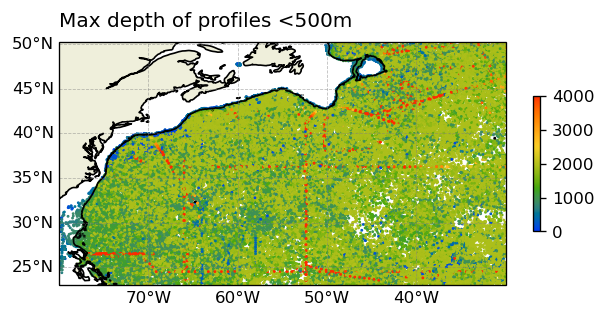

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
plt.scatter(dsp2.longitude,dsp2.latitude,c = dsp2.depth_prof,s = .5,cmap = cc.cm["rainbow"],vmin = 0)
ds_bat['bathymetry'].plot.contour(**kw,ax = ax)
ax.add_feature(land_feature, edgecolor='black')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.colorbar(shrink=0.25)
ax.set_title('Max depth of profiles <500m',loc = 'left')
plt.savefig(pathfig + 'Map_max_depth_500m.png', transparent=False)
plt.show()

In [7]:
#Save to netcdf
dsp2.to_netcdf("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_alldepth_bathy500_1993-2019.nc")